# Forward UQ with Dynamic Low Rank Approximaton
----------

We consider the problem of propagating the effect of an uncertain initial condition through the nonlinear Burgers equation:

$$\begin{align} \frac{\partial \rho}{\partial t} = \nu \Delta \rho - \rho \nabla\rho = \mathcal{L}(\rho), \ (x,t) \in [0,\pi]\times [0,1] \end{align}$$ 

with periodic boundary conditions. The initial condition takes the form 

$$\begin{align} \rho(x,0) = \rho_0(x) + \rho'(x,\xi),\end{align}$$
i.e., a superposition of a deterministic component and stochastic flucations. 
The deterministic component takes the form
$$\begin{align} 
    \rho_0(x) = \frac{1}{2}(e^{\cos(x)} - 1.5)\sin(x + 0.74\pi)
\end{align}$$
while the stochastic vibration can be described as
$$\begin{align}
    \rho'(x,\xi) = \xi_1 \sin(2\pi x) +\xi_2 \sin(3\pi x)
\end{align}$$
where $\xi_1, \xi_2 \sim U([-\frac{1}{2},\frac{1}{2}]).$

In the following we set up the problem by implementing a simple semi-discretization of Equation (1). We use centered differences on a uniform grid with $n = 1000$ nodes to approximate Laplacian and gradient. 

In [1]:
using LowRankIntegrators, LinearAlgebra, Plots, SparseArrays, DifferentialEquations;

┌ Info: Precompiling LowRankIntegrators [a4d2327a-b40c-407e-b18c-dbb78b346b8e]
└ @ Base loading.jl:1342


In [2]:
n = 1000 # spatial discretization

l = π # length of spatial domain
Δx = l/n # step size
x_range = Δx/2:Δx:l-Δx/2 # uniform grid

# boundary conditions
left(i) = i > 1 ? i - 1 : n
right(i) = i < n ? i + 1 : 1

# discretized diff operators
# laplacian (times viscosity)
Δ = spzeros(n, n)
ν = 0.005
for i in 1:n
    Δ[i,left(i)] = ν/Δx^2
    Δ[i,i] = -2ν/Δx^2
    Δ[i,right(i)] = ν/Δx^2
end

# gradient
∇ = spzeros(n, n)
for i in 1:n
    ∇[i,left(i)] = -1/2/Δx
    ∇[i,right(i)] = 1/2/Δx
end

function burgers(ρ, (∇,Δ), t)
    return Δ*ρ - (∇*ρ) .* ρ 
end

burgers (generic function with 1 method)

In order to get a representative sample of the probability space, we sample each uncertain dimension on a 20 uniformly spaced grid for a total of 400 realizations:

In [3]:
# uncertainty range
m = 20 # parameter realizations scale as m^2
σ = [0.5,0.5]
ξ_range = [(ξ_1,ξ_2) for ξ_1 in range(-1,1,length=m), ξ_2 in range(-1,1,length=m)];

Sampling each of these realizations by simulating the full-order high-fidelity model is quite computationally demanding. To circumvent this issue we will attempt to find an approximate but more tractable solution to the sampling problem via dynamical low rank approximation. To that end, let us now consider the parametric solution of Equation (1) $\{\rho(t,x,\xi): x\in [0,\pi], \xi \in [-\frac{1}{2},\frac{1}{2}]^2\}$ in a matrix $\hat{\rho}(t) \in \mathbb{R}^{n \times m^2}$ in which the rows index the (discretized) spatial domain and the columns the (discretized and properly ordered) stochastic domain. Now we will assume that $\hat{\rho}$ can be well approximated by a matrix of low rank $r$. That way, instead of keeping track of the $n m^2$ entries of $\hat{\rho}$ at every time step of integration, we only need to compute and store $(n+m^2)r + r^2$ values of an SVD like low rank factorization: $\hat{\rho}(t) = U(t) S(t) V(t)^\top$ where $U(t)\in \mathcal{V}_{n,r}$, $V(t) \in\mathcal{V}_{m^2,r}$ and $S(t) \in \mathbb{R}^{r\times r}$. In order to evolve the factors $U(t), S(t), V(t)$, we can use the Dirac-Frenkel variational principle which states that
$$
    \dot{U}, \dot{S}, \dot{V} \in \text{arg}\,\min \| \dot{U S V^\top} - \mathcal{L}(USV^\top)\|_F^2.
$$
LowRankIntegrators.jl implements several integrators (and some dynamically orthogonal schemes) which approximate the evolution of the factors according to the above princple. In order to use it, only few primitives must be used. First, we need to define an inital condition for the low rank approximation of $\hat{\rho}(0)$. We use the truncated SVD here to obtain this approximation:

In [18]:
#initial condition
ub(x) = 0.5*(exp.(cos.(x)) .- 1.5).*sin.(x .+ 2π*0.37) # deterministic initial condition
uprime(x,ξ,σ) = σ[1]*ξ[1]*sin.(2π*x) .+ σ[2]*ξ[2]*sin.(3π*x) # stochastic fluctuation
ρ0_mat = hcat([ub(x_range) + uprime(x_range, ξ, σ) for ξ in ξ_range]...) # full rank initial condition

r = 10 # approximation rank
lr_ρ0 = truncated_svd(ρ0_mat,r); # intial condition

Next, we define a `MatrixDEProblem` (referring to Matrix Differential Equation Problem) in which we supply the right-hand-side of the discretized Burger's equation, a low rank approximation of the initial condition, and time horizon. Then we simply call LowRankIntegrators.solve with an appropriate choice of step size and integration algorithm (here we choose the recently proposed Unconventional Algorithm).

In [19]:
# low rank approximation
dt = 1e-2 # time step 
lr_prob = MatrixDEProblem((ρ,t) -> burgers(ρ, (∇,Δ), t),  lr_ρ0, (0.0, 1.0)) # defines the matrix differential equation problem
t_lr = @elapsed lr_sol = LowRankIntegrators.solve(lr_prob, UnconventionalAlgorithm(), dt) # solves the low rank approximation

7.362349875

Finally, we would like to see if our low rank assumption was reasonable and how much it saved us in computational cost. To that end, we actually sample the full order model here since it is costly but still tractable for this toy example. Note further that we take advantage of mutation to speed up the calculation for a fair comparison. If we were to use the `burgers`, the results would be even better. 

In [16]:
# full model
function burgers!(dρ, ρ, (∇,Δ), t)
    dρ[:] .= Δ*ρ - (∇*ρ) .* ρ
end
savepoints = 0:dt:1.0
ode_prob = ODEProblem(burgers!, ones(n), (0.0, 1.0), (∇, Δ))
true_sols = []
t_full = @elapsed for ξ in ξ_range
    _prob = remake(ode_prob, u0 = ub(x_range) + uprime(x_range, ξ, σ))
    _sol = Array(DifferentialEquations.solve(_prob, saveat=savepoints))
    push!(true_sols, _sol)
end


207.116771125

Right away, we see the speed up is quite substantial:

In [20]:
speed_up = t_full/t_lr

28.131883792740837

Also, the solutions agree fairly well up to strong overshoots at shocks which can be remedied with filtering:

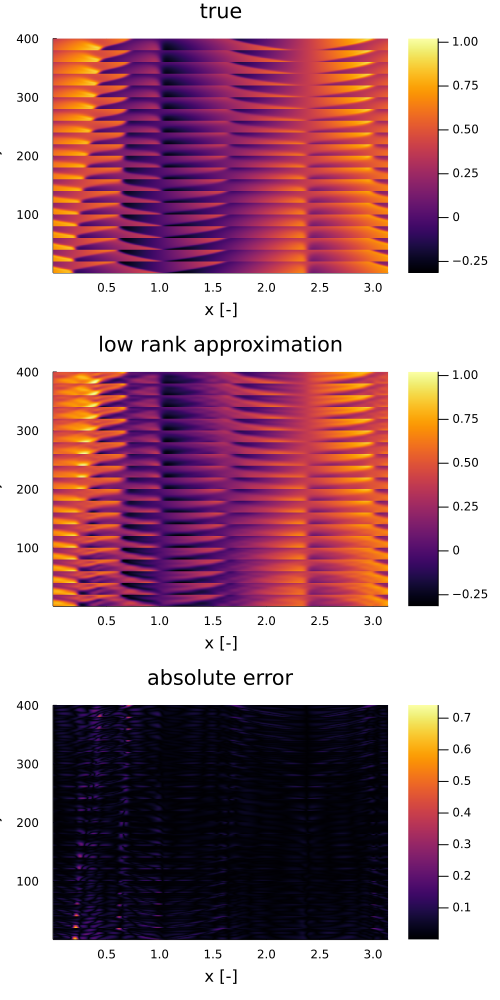

In [21]:
final_traj_true = hcat([sol[:,end] for sol in true_sols]...)
final_traj_lr = Matrix(lr_sol.Y[end])
clims = (min(minimum(final_traj_true), minimum(final_traj_true)), max(maximum(final_traj_true), maximum(final_traj_lr)))
final_true = heatmap(x_range, 1:m^2, final_traj_true', clims = clims, title = "true");
final_lr = heatmap(x_range, 1:m^2, final_traj_lr', clims = clims, title = "low rank approximation");
error = heatmap(x_range, 1:m^2, abs.(final_traj_true' - final_traj_lr'), title="absolute error");
plot(final_true, final_lr, error, xlabel="x [-]", ylabel="ξ", layout = (3,1), size=(500, 1000))

Despite the overshoot at shocks, however, we see that on average the error is as low as ~6%.

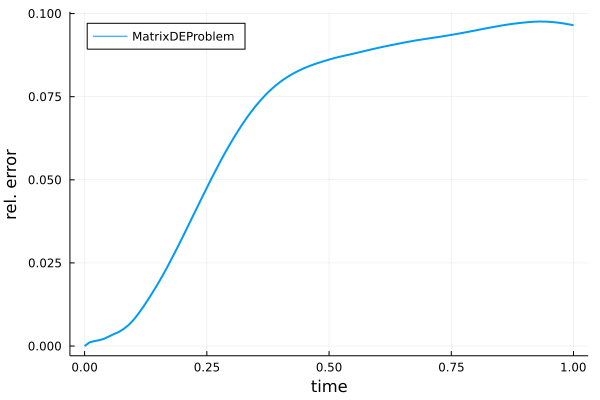

In [22]:
true_trajs = [hcat([sol[:,k] for sol in true_sols]...) for k in 1:length(savepoints)];
plot(savepoints[1:end], [norm(true_trajs[i] - Matrix(lr_sol.Y[i]))/norm(true_trajs[i]) for i in 1:length(savepoints)],
     xlabel = "time", ylabel = "rel. error", label = "MatrixDEProblem", linewidth = 2, legend = :topleft)


Another interesting use case of dynamic low rank approximation is that of cheaply updating the dynamic low rank approximation of a matrix. Here we consider the sampled solutions of Burger's equation and attempt finding a suitable low rank approximation which changes over time. In LowRankIntegrators.jl we refer to such a problem as `MatrixDataProblem`. To define a `MatrixDataProblem` we simply need to supply a time-varying matrix, i.e., a map $t \mapsto A(t)$, a low rank approximation of $A(0)$, and a time horizon. Then, a simple `solve` call with a specified approximation algorithm and step size yields a dynamically evolving low rank approximation. 

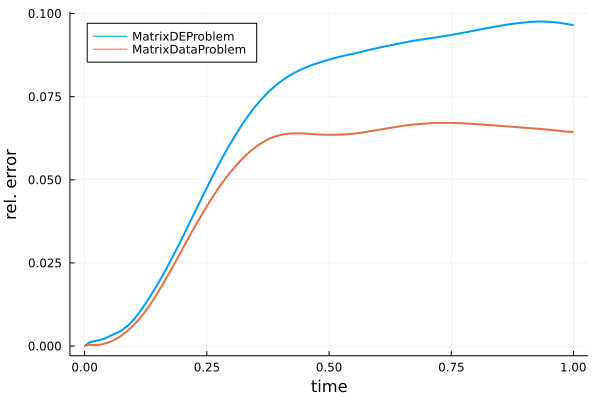

In [23]:
function interpolate_data(t, data, dt)
    i = floor(Int64,t/dt) + 1
    if i > length(data) -1
        return data[i]
    else
        return data[i] + (t - savepoints[i])/dt*(data[i+1]-data[i])
    end
end

data_prob = MatrixDataProblem(t -> interpolate_data(t, true_trajs, dt), lr_ρ0, (0.0, 1.0))
t_data = @elapsed data_sol = LowRankIntegrators.solve(data_prob, GreedyIntegrator(), dt)
plot!(savepoints, [norm(true_trajs[i] - Matrix(data_sol.Y[i]))/norm(true_trajs[i]) for i in 1:length(savepoints)],
      linewidth = 2, label="MatrixDataProblem")

A natural question one could ask is "Why not simply apply the SVD at every time step to extract the best possible low rank approximation?". To answer that question, let's just do it:

In [24]:
t_svd = @elapsed lower_bound = [truncated_svd(true_trajs[i], r) for i in 1:length(true_trajs)];

This is certainly tractable in this case but it is a lot slower:

In [25]:
speed_up = t_svd/t_data

26.04325205544258

This scaling advantage only grows as the problem sizes become larger and larger. But do we sacrifice a lot of accuracy? This really depends on the problem but here it turns out we loose essentially nothing.

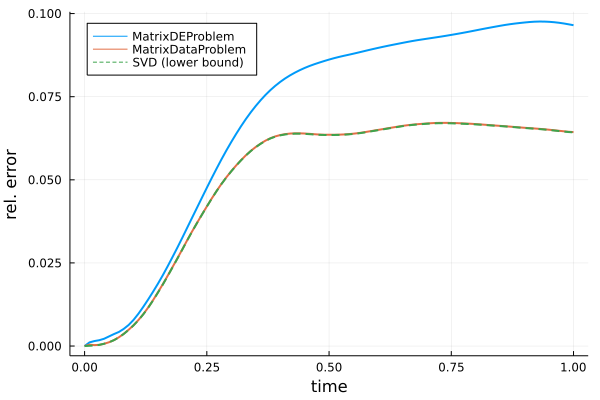

In [26]:
plot!(savepoints, [norm(true_trajs[i] - Matrix(lower_bound[i]))/norm(true_trajs[i]) for i in 1:length(savepoints)], 
      linewidth = 2, linestyle = :dash, label = "SVD (lower bound)")